<a href="https://colab.research.google.com/github/Tomer-Gil/impr_ex5_StyleGAN/blob/main/Copy_of_IMPR_Ex5_Deep_Style_Image_Prior_2022_2023_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Important!
When initially opening the notebook there should be a text to the right of the "Help" menu saying "Changes will not be saved".
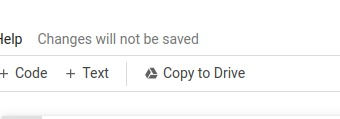

To ensure you can make changes to the notebook save a copy of it to your own drive and work on that one. You can do that by going to "File" -> "Save a copy in Drive".

**Failing to do so will result in code loss!**

 **Note** Make sure you are the only one that has access to it!


In [ ]:
#@markdown #Image Processing - 67829. { display-mode: "form" }
#@markdown ##Exercise 5:  Deep Style Image Prior
#@markdown ##Due date: 20.03.2024 at 23:59
#@title{ display-mode: "form" }

#@markdown
#@markdown This exercise is a bit different than the rest of the exercises in the course.
#@markdown The submissions will be a PDF file with your answers and results to the exercise
#@markdown as well as some files so that we can verify the authenticity of your results.
#@markdown This notebook provides the basic code, but you do not need to adhere to some specific API
#@markdown and we will not be running unit tests on your code.
#@markdown We will however, be going over your code and running it manually.
#@markdown Moreover, we will be running tests to ensure the authenticity of your solution and detect plagiarism
#@markdown
#@markdown
#@markdown Before you start working on the exercise it is recommended that you review the lecture slides covering neural networks,
#@markdown
#@markdown
#@markdown **NOTE**: Neural networks are typically trained on GPUs, without GPUs training takes much longer.
#@markdown To enable GPU tranining click on "Runtime" -> "Change runtime type" -> "GPU" -> "SAVE".
#@markdown
#@markdown **NOTE**: A short guide on debugging your code using colab is availble [here](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.06-Errors-and-Debugging.ipynb#scrollTo=qnIn-rWFqoww).

#@markdown But first, we have to download all of the dependencies and install them.
#@markdown Play this cell to download it and get everything ready. markdown This may take a few minutes.


!mkdir impr_ex5_resources
%cd impr_ex5_resources
#!wget "https://www.cs.huji.ac.il/~impr/shape_predictor_68_face_landmarks.dat" -O shape_predictor_68_face_landmarks.dat
#!wget "https://www.cs.huji.ac.il/~impr/align_faces.py" -O align_faces.py
# !wget "https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar" -O stylegan2-ada-pytorch.tar
!wget -v --max-redirect=5 --user-agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"  "https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar" -O stylegan2-ada-pytorch.tar
!tar -xvf stylegan2-ada-pytorch.tar
!rm -f stylegan2-ada-pytorch.tar

import sys
ROOT_PATH="/content/impr_ex5_resources/stylegan2-ada-pytorch"
sys.path.append(ROOT_PATH)


!pip install ninja
!pip install mediapy
CHECKPOINTS_PATH = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"



import copy
import os
from time import perf_counter
import click
import imageio
import numpy as np
import PIL.Image
import torch
import torch.nn.functional as F

import dnnlib
import legacy
import numpy as np
from skimage.draw import line
from torch.nn.functional import conv2d,conv1d
import mediapy as media
from IPython.display import clear_output


/content/impr_ex5_resources
--2024-03-27 13:49:11--  https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar
Resolving www.cs.huji.ac.il (www.cs.huji.ac.il)... 128.139.7.26
Connecting to www.cs.huji.ac.il (www.cs.huji.ac.il)|128.139.7.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-tar]
Saving to: ‘stylegan2-ada-pytorch.tar’

stylegan2-ada-pytor     [   <=>              ]  95.71M   612KB/s    in 2m 45s  

2024-03-27 13:51:57 (595 KB/s) - ‘stylegan2-ada-pytorch.tar’ saved [100364800]

stylegan2-ada-pytorch/
stylegan2-ada-pytorch/metrics/
stylegan2-ada-pytorch/._dataset_tool.py
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
stylegan2-ada-pytorch/dataset_tool.py
stylegan2-ada-pytorch/._.DS_Store
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.FinderInfo'
stylegan2-ada-pytorch/.DS_Store
stylegan2-ada-pytorch/._style_mixing.py
tar: Ignoring unknown extended header keyw

# Mounting Google Drive

In [ ]:
#@markdown **NOTE**: It is strongly advised you save your results to Google
#@markdown Drive as they will be deleted from Colab once it restarts.
#@markdown To connect Google Drive run this cell.
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Below is the root dir of your Google Drive. To choose the destenation of the dir to save and read from, create it in your Google Drive and add the relative path to the "GDRIVE_SAVE_REL_PATH" variable below.

In [ ]:
ROOT_GDRIVE_PATH="/content/gdrive/MyDrive/"
GDRIVE_SAVE_REL_PATH = r"67829 image processing/ex5"
FULL_GDRIVE_SAVE_PATH = ROOT_GDRIVE_PATH + GDRIVE_SAVE_REL_PATH

# General Variables

In [ ]:
GAUSSIAN_BLUR_DEGRADATION= 'GAUSSIAN_BLUR_DEGRADATION'
GRAYSCALE_DEGRADATION = 'GRAYSCALE_DEGRADATION'
INPAINTING_DEGRADATION = 'INPAINTING_DEGRADATION'
NO_DEGRADATION= 'NO_DEGRADATION'


# Image Alignment

In [ ]:
# The align_faces.py script takes in an input image path, an output image path, and a dat file path. The dat file is already downloaded for you, so leave it as it is.
# It is advised that you save the files to google drive as restarting Colab will erase them.
# !python "$ROOT_PATH/align_faces/align_faces.py" "$FULL_GDRIVE_SAVE_PATH/input/mccartney1/mccartney1.jpg" "$FULL_GDRIVE_SAVE_PATH/mccartney1_aligned.jpg" "$ROOT_PATH/align_faces/shape_predictor_68_face_landmarks.dat"
# !python "$ROOT_PATH/align_faces/align_faces.py" "$FULL_GDRIVE_SAVE_PATH/input/girl.jpg" "$FULL_GDRIVE_SAVE_PATH/girl_aligned.jpg" "$ROOT_PATH/align_faces/shape_predictor_68_face_landmarks.dat"
# !python "$ROOT_PATH/align_faces/align_faces.py" "$FULL_GDRIVE_SAVE_PATH/input/boy.jpg" "$FULL_GDRIVE_SAVE_PATH/boy_aligned.jpg" "$ROOT_PATH/align_faces/shape_predictor_68_face_landmarks.dat"
# !python "$ROOT_PATH/align_faces/align_faces.py" "$FULL_GDRIVE_SAVE_PATH/input/girl2.jpg" "$FULL_GDRIVE_SAVE_PATH/girl2_aligned.jpg" "$ROOT_PATH/align_faces/shape_predictor_68_face_landmarks.dat"
# !python "$ROOT_PATH/align_faces/align_faces.py" "$FULL_GDRIVE_SAVE_PATH/input/girl3.jpg" "$FULL_GDRIVE_SAVE_PATH/girl3_aligned.jpg" "$ROOT_PATH/align_faces/shape_predictor_68_face_landmarks.dat"

# Degradation Functions

In [ ]:
    # ********************************************************************************************************
    # ******************                   NEED TO ADD DEGRADATION FUNCTIONS                ******************
    # ********************************************************************************************************
def rgb_to_gray(synth_images):
  """synth_images should by torch tensor of simensions 1x3x1024x1024"""
  # Splitting the RGB image tensor into its channels
  # red_channel, green_channel, blue_channel = synth_images[0, 0, :, :], synth_images[0, 1, :, :], synth_images[0, 2, :, :]

  # Calculate grayscale image using the luminance formula

  # Neriya
  # rgb_arr = torch.stack((red_channel, green_channel, blue_channel), dim=2).clamp(0,255).to(torch.uint8).cpu().detach().numpy()
  # rgb_image = PIL.Image.fromarray(np.uint8(rgb_arr), mode='RGB')
  # grayscale_image = rgb_image.convert('L')
  # grayscale_array = np.asarray(grayscale_image)
  # temp = torch.tensor(grayscale_array, device='cuda:0', dtype=torch.uint8)
  # synth_images = torch.stack([temp] * 3, dim=0).unsqueeze(0)

  # gray_image = 0.299 * red_channel + 0.587 * green_channel + 0.114 * blue_channel
  # synth_images = torch.stack((gray_image, gray_image, gray_image), dim=2).unsqueeze(0).permute(0, 3, 1, 2)
  # synth_images = gray_image.unsqueeze(0).expand(1, 3, 1024, 1024)

  synth_images = ((synth_images.to(torch.float64) + 1) / 2)
  synth_images = torch.sum(synth_images * torch.tensor([0.299, 0.587, 0.114], dtype=torch.float64, device='cuda:0').view(1, 3, 1, 1), dim=1, keepdim=True).repeat(1,3,1,1)
  # synth_images = transforms.Grayscale(num_output_channels=3)(synth_images)

  return (synth_images * 2) - 1

def inpaint(image):
  """image should by torch tensor of simensions 1x3x1024x1024.
  mask should be 1024x1024 or something broadcastable to 1x3x1024x1024,
  e.g. 3x1024x1024 or 1x3x1024x1024"""
  mask_path = f'{FULL_GDRIVE_SAVE_PATH}/IMPR_Ex5_SM/fei_fei_li_inpainting_mask.png'
  mask_pil = PIL.Image.open(mask_path).convert('L')
  mask_float64 = np.array(mask_pil, dtype=np.float64)
  mask_float64[mask_float64 > 157] = 255
  mask_float64[mask_float64 <= 157] = 0
  mask_float64 = mask_float64 / 255
  mask=torch.tensor(mask_float64, device='cuda:0')

  res = (image + 1) * mask - 1

  return res

# GAN Inversion

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import transforms
from matplotlib import pyplot as plt


def run_latent_optimization(outdir,
    degradation_mode,
    G,
    imgs_to_disply_dict,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = 10000,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    latent_dist_reg_weight     = 0.001,
    device: torch.device

):
    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore

    # Compute w stats.
    print(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples.cpu().numpy().astype(np.float32)
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 18, C]
    w_avg_original = torch.from_numpy(w_avg).to(device).float()
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Load VGG16 feature detector.
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with dnnlib.util.open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to(device)

    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)

    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True)
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    # Save loss
    loss_values = []

    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth image from opt_w
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = w_opt + w_noise
        synth_images = G.synthesis(ws, noise_mode='const')

        # Prep to save synth image
        synth_image_save = (synth_images + 1) * (255/2)
        synth_image_save = synth_image_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
        # print(synth_images.shape)
        # print(synth_image_save.shape)


        # ********************************************************************************************************
        # ******************                   NEED TO FILL IN THE FOLLOWING CODE               ******************
        # ********************************************************************************************************
        if  degradation_mode == INPAINTING_DEGRADATION:
          synth_images = inpaint(synth_images)
        elif degradation_mode == GRAYSCALE_DEGRADATION:
          synth_images = rgb_to_gray(synth_images)
        elif degradation_mode == GAUSSIAN_BLUR_DEGRADATION:
          pass
        # ********************************************************************************************************
        # ******************                          END CODE TO ADD SECTION                   ******************
        # ********************************************************************************************************


        # Prep to save and show images
        synth_image_degraded_save = (synth_images + 1) * (255/2)
        # if degradation_mode == GRAYSCALE_DEGRADATION:
        #     synth_image_degraded_save = synth_image_degraded_save.clamp(0, 255).to(torch.uint8).cpu().numpy()
        # else:
        #   synth_image_degraded_save = synth_image_degraded_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
        synth_image_degraded_save = synth_image_degraded_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

        if step % 20 == 0:
          imgs_to_disply_dict["Generated Image"]=synth_image_save
          imgs_to_disply_dict["Generated Degraded Image"]=synth_image_degraded_save
          clear_output(wait=True)
          media.show_images(imgs_to_disply_dict,height=256)
        if step % 100 == 0:
          PIL.Image.fromarray(synth_image_save, 'RGB').save(f'{outdir}/intermidiate_%d_not_degraded.png'%step)
          # if degradation_mode == GRAYSCALE_DEGRADATION:
          #   PIL.Image.fromarray(synth_image_degraded_save, '1').save(f'{outdir}/intermidiate_%d_degraded.png'%step)
          # else:
            # PIL.Image.fromarray(synth_image_degraded_save, 'RGB').save(f'{outdir}/intermidiate_%d_degraded.png'%step)
          PIL.Image.fromarray(synth_image_degraded_save, 'RGB').save(f'{outdir}/intermidiate_%d_degraded.png'%step)


        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)

        # Compute loss
        percep_loss = (target_features - synth_features).square().sum()
        latent_dist_reg = F.l1_loss(w_avg_original, w_opt)
        loss = percep_loss + reg_loss * regularize_noise_weight  + latent_dist_reg_weight * latent_dist_reg
        # Append loss to list
        loss_values.append(loss.item())

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        print(f'step {step+1:>4d}/{num_steps}: percep_loss {percep_loss:<4.2f} latent_dist_reg {latent_dist_reg:<4.2f} loss {float(loss):<5.2f}' )

        # Save inverted latent for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    # Return optimized latent vector
    return w_out, loss_values

In [ ]:

def invert_image(degradation_mode,
                   target_fname,
                   outdir,
                   image_name,
                   seed=303,
                   num_steps=1000,
                   latent_dist_reg_weight=0.001):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Load networks.
    print('Loading networks from "%s"...' % CHECKPOINTS_PATH)
    device = torch.device('cuda')
    with dnnlib.util.open_url(CHECKPOINTS_PATH) as fp:
        networks = legacy.load_network_pkl(fp)
        G = networks['G_ema'].requires_grad_(False).to(device)


    # Load target image.
    if not os.path.exists(outdir):
      os.makedirs(outdir)
    target_pil = PIL.Image.open(target_fname).convert('RGB')
    w, h = target_pil.size
    s = min(w, h)
    target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
    target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
    target_uint8 = np.array(target_pil, dtype=np.uint8)
    target=torch.tensor([target_uint8.transpose([2, 0, 1])], device=device)
    target_images = target[0].unsqueeze(0).to(device).to(torch.float32)

    # ********************************************************************************************************
    # ******************                   NEED TO FILL IN THE FOLLOWING CODE               ******************
    # ********************************************************************************************************
    if  degradation_mode == INPAINTING_DEGRADATION:
      target[0] = ((inpaint(target[0].to(torch.float64) * (2 / 255) - 1)) + 1) * (255 / 2)
    elif degradation_mode == GRAYSCALE_DEGRADATION:
      if image_name != "Turing":
        target[0] = ((rgb_to_gray(((target[0].to(torch.float64) / 255) * 2) - 1) + 1) / 2) * 255
    elif degradation_mode == GAUSSIAN_BLUR_DEGRADATION:
      pass
    # ********************************************************************************************************
    # ******************                          END CODE TO ADD SECTION                   ******************
    # ********************************************************************************************************

    #Save target image
    target_to_save = target.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(target_to_save, 'RGB').save(f'{outdir}/original_degraded_image.png')
    imgs_to_disply_dict = {
        "Original Image":target_uint8,
        "Original Degraded Image":target_to_save,
              }

    # Run latent optimization
    start_time = perf_counter()
    optimization_steps, loss_values = run_latent_optimization(
        outdir,
        degradation_mode,
        G,
        imgs_to_disply_dict,
        target[0],
        num_steps=num_steps,
        device=device,
        latent_dist_reg_weight=latent_dist_reg_weight
    )

    print (f'Elapsed: {(perf_counter()-start_time):.1f} s')
    os.makedirs(outdir, exist_ok=True)

    # Save final inverted image and latent vector.
    inverted_latent = optimization_steps[-1]
    synth_image = G.synthesis(inverted_latent.unsqueeze(0), noise_mode='const')
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(synth_image, 'RGB').save(f'{outdir}/final_inverted_image.png')
    np.savez(f'{outdir}/inverted_latent.npz', latent=inverted_latent.unsqueeze(0).cpu().numpy())

    # Save loss plot
    # Uncomment if you want to plot
    plt.plot(np.array(loss_values))
    plt.title(f"Loss per Iteration for {image_name} Image, {num_steps} Steps, {latent_dist_reg_weight} Latent Dist. Reg. Weight")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.savefig(f'{outdir}/loss_plot.png')

Original Image,Original Degraded Image,Generated Image,Generated Degraded Image

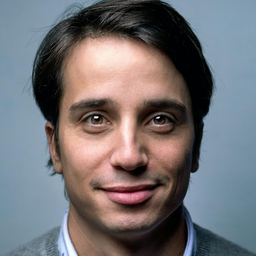
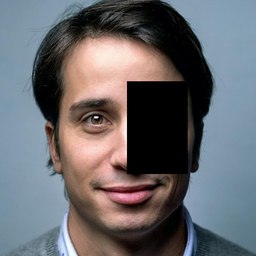
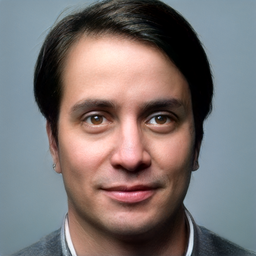
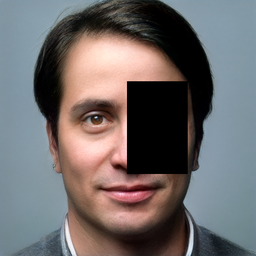

step  461/1000: percep_loss 0.15 latent_dist_reg 0.45 loss 12.65
step  462/1000: percep_loss 0.15 latent_dist_reg 0.44 loss 18.96
step  463/1000: percep_loss 0.15 latent_dist_reg 0.44 loss 22.90
step  464/1000: percep_loss 0.15 latent_dist_reg 0.44 loss 26.63
step  465/1000: percep_loss 0.15 latent_dist_reg 0.44 loss 25.54
step  466/1000: percep_loss 0.16 latent_dist_reg 0.44 loss 21.93
step  467/1000: percep_loss 0.14 latent_dist_reg 0.44 loss 19.48
step  468/1000: percep_loss 0.15 latent_dist_reg 0.44 loss 13.90
step  469/1000: percep_loss 0.15 latent_dist_reg 0.44 loss 8.25 
step  470/1000: percep_loss 0.15 latent_dist_reg 0.44 loss 9.81 
step  471/1000: percep_loss 0.15 latent_dist_reg 0.44 loss 12.24
step  472/1000: percep_loss 0.15 latent_dist_reg 0.44 loss 8.03 
step  473/1000: percep_loss 0.15 latent_dist_reg 0.44 loss 4.84 
step  474/1000: percep_loss 0.15 latent_dist_reg 0.44 loss 7.91 
step  475/1000: percep_loss 0.15 latent_dist_reg 0.44 loss 8.55 


KeyboardInterrupt: 

In [ ]:
# invert_image("", f"{FULL_GDRIVE_SAVE_PATH}/input/mccartney1/mccartney1_aligned.jpg", f"{FULL_GDRIVE_SAVE_PATH}/output")
# invert_image(GRAYSCALE_DEGRADATION, f"{FULL_GDRIVE_SAVE_PATH}/IMPR_Ex5_SM/alan_turing_grayscale.png", f"{FULL_GDRIVE_SAVE_PATH}/output", image_name="Turing")
# invert_image(INPAINTING_DEGRADATION, f"{FULL_GDRIVE_SAVE_PATH}/IMPR_Ex5_SM/fei_fei_li_original.png", f"{FULL_GDRIVE_SAVE_PATH}/output")
# invert_image(GRAYSCALE_DEGRADATION, f"{FULL_GDRIVE_SAVE_PATH}/input/girl_aligned.jpg", f"{FULL_GDRIVE_SAVE_PATH}/output")
# invert_image(INPAINTING_DEGRADATION, f"{FULL_GDRIVE_SAVE_PATH}/input/boy_aligned.jpg", f"{FULL_GDRIVE_SAVE_PATH}/output", image_name="Boy", latent_dist_reg_weight=0.01)
# invert_image(GRAYSCALE_DEGRADATION, f"{FULL_GDRIVE_SAVE_PATH}/input/girl2_aligned.jpg", f"{FULL_GDRIVE_SAVE_PATH}/output", image_name="Girl", num_steps=1000, latent_dist_reg_weight=0.5)
# invert_image(GRAYSCALE_DEGRADATION, f"{FULL_GDRIVE_SAVE_PATH}/input/girl3_aligned.jpg", f"{FULL_GDRIVE_SAVE_PATH}/output", image_name="Girl", num_steps=1000, latent_dist_reg_weight=0.75)
# invert_image(GRAYSCALE_DEGRADATION, f"{FULL_GDRIVE_SAVE_PATH}/input/girl3_aligned.jpg", f"{FULL_GDRIVE_SAVE_PATH}/output", image_name="Girl", num_steps=800, latent_dist_reg_weight=0.65)